In [64]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class = 80
fixed_size       = tuple((500, 500))
train_path       = "dataset/train"
h5_data          = 'output/data.h5'
h5_labels        = 'output/labels.h5'
bins             = 40

In [65]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

def fd_ordb(image):
    orb = cv2.ORB_create(nfeatures=1500)
    keypoints_orb, descriptors = orb.detectAndCompute(image, None)
    return np.float32(descriptors.flatten())

In [66]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['banana', 'coca cola', 'flynn paff']


In [67]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        try:
            image = cv2.imread(file)
            image = cv2.resize(image, fixed_size)
        except:
            print("Fallo la imagen: {}".format(file))
        else:
            ####################################
            # Global Feature extraction
            ####################################
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
            #fv_orb = fd_ordb(image)

            ###################################
            # Concatenate global features
            ###################################
            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

            # update the list of labels and feature vectors
            labels.append(current_label)
            global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

Fallo la imagen: dataset/train/banana/75.jpg
Fallo la imagen: dataset/train/banana/76.jpg
Fallo la imagen: dataset/train/banana/77.jpg
Fallo la imagen: dataset/train/banana/78.jpg
Fallo la imagen: dataset/train/banana/79.jpg
Fallo la imagen: dataset/train/banana/80.jpg
[STATUS] processed folder: banana
Fallo la imagen: dataset/train/coca cola/78.jpg
Fallo la imagen: dataset/train/coca cola/79.jpg
Fallo la imagen: dataset/train/coca cola/80.jpg
[STATUS] processed folder: coca cola
[STATUS] processed folder: flynn paff
[STATUS] completed Global Feature Extraction...


In [68]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] feature vector size (231, 64020)
[STATUS] training Labels (231,)


In [45]:
# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
[STATUS] target labels shape: (231,)
[STATUS] end of training..


# Plot 2-dimensional

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA

In [47]:
df = pd.DataFrame(rescaled_features, columns=['f_{}'.format(i) for i in range(rescaled_features.shape[1])])
df['label'] = labels

In [48]:
df.sample(3)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_64011,f_64012,f_64013,f_64014,f_64015,f_64016,f_64017,f_64018,f_64019,label
220,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.491702,0.900045,0.032733,0.000319,8.521237e-08,0.000000,0.073576,0.589751,0.270762,flynn paff
228,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.440366,0.990075,0.050957,0.000779,3.589334e-06,0.002369,0.073576,0.589627,0.270762,flynn paff
75,0.0,0.0,0.0,0.000011,0.00001,0.000144,0.00122,0.001205,0.00129,0.001234,...,0.418395,0.930257,0.034216,0.003391,3.091626e-04,0.002549,0.073573,0.589475,0.270763,coca cola


In [49]:
pca = sklearnPCA(n_components=2)

In [50]:
transformed = pd.DataFrame(pca.fit_transform(rescaled_features))
transformed["labels"] = labels

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


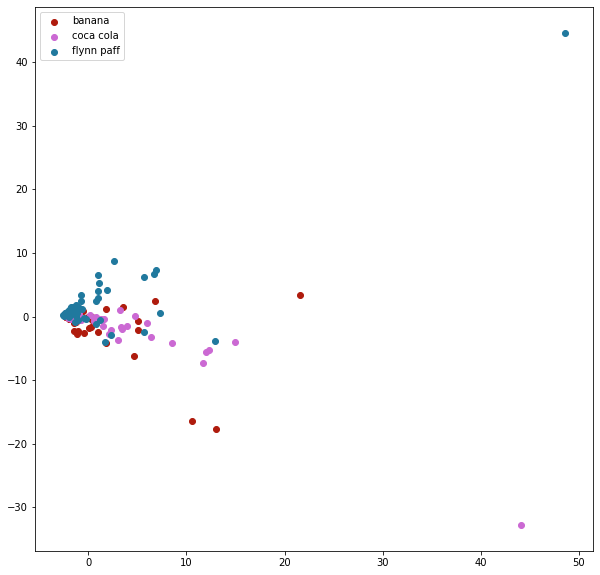

In [52]:
plt.figure(figsize=(10, 10))

for label in transformed["labels"].unique():
    plt.scatter(transformed[transformed.labels == label][0], \
                transformed[transformed.labels == label][1], label=label, c=np.random.rand(3,))
    
plt.legend()
plt.show()

# Training

In [41]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.10
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (231, 64020)
[STATUS] labels shape: (231,)
[STATUS] training started...


/home/rodrigo/python-virtual-environments/changEat/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [42]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (207, 64020)
Test data   : (24, 64020)
Train labels: (207,)
Test labels : (24,)


In [ ]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

LR: 0.917857 (0.022163)


# Testing

In [20]:
train_labels

['banana', 'flynn paff']

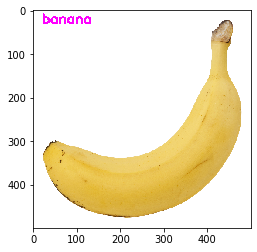

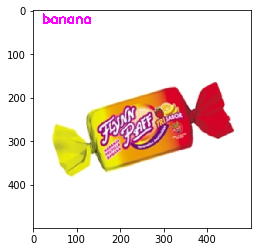

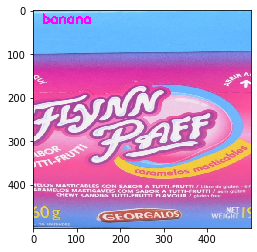

In [26]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt

for name, model in models:
    if name == 'RF':
        clf = model
# create the model - Random Forests
#clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # scale features in the range (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_feature.reshape(1,-1))

    # predict label of test image
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,0,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# New features

In [3]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [4]:
train_path

'dataset/train'

In [5]:
path1 = train_path + "/banana/18.jpg"
path2 = train_path + "/coca cola/4.jpg"
path3 = train_path + "/flynn paff/62.jpg"

In [6]:
image = cv2.imread(path1)

In [7]:
#sift = cv2.SIFT_create()
#surf = cv2.SURF_create()
orb = cv2.ORB_create(nfeatures=1500)

In [8]:
keypoints_orb, descriptors = orb.detectAndCompute(image, None)

In [9]:
descriptors.flatten()

array([ 57,  22,  99, ...,  92,  61, 223], dtype=uint8)

In [56]:
def fd_ordb(image):
    orb = cv2.ORB_create(nfeatures=1500)
    keypoints_orb, descriptors = orb.detectAndCompute(image, None)
    return np.float32(descriptors.flatten())

In [57]:
fd_ordb(image)

array([  2., 204.,   2., ..., 204., 157., 223.], dtype=float32)

In [58]:
fd_histogram(image)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [59]:
np.hstack([fd_ordb(image), fd_histogram(image)])

array([  2., 204.,   2., ...,   0.,   0.,   0.], dtype=float32)